# Initialization

### Hyper-parameters (variables)

In [ ]:
PRINT_FREQ = 1  # sparsity calculations' print frequency w/ modulus operandi.
KERNEL_SIZE = 9  # Kernel value of the dimensions for convolutional features.
WINDOW_SIZE = 7  # number of datapoints for each windowed input sample.
BATCH_SIZE = 60  # number of samples for each windowed batch split.
LCA_ITERS = 1000  # number of LCA timesteps per forward pass.
FEATURES = 50  # number of dictionary features to learn.
LAMBDA = 2  # neuron activation threshold.
STRIDE = 2  # LCA convolutional stride.
EPOCHS = 1  # periods of training.
TAU = 200  # LCA time constant.

INPUT_CROP_SIZE = 10  # PERCENTAGE TO SHORTEN THE INPUT LENGTH.
NUM_INPUT_REP = 3600  # TOTAL AMOUNT OF SAMPLES FOR THE EXPERIMENT.
SPLITTED_BATCHES = int(NUM_INPUT_REP // BATCH_SIZE // INPUT_CROP_SIZE)

### Dependencies

In [ ]:
# system modules
import glob
import math
import os
import time

# numpy, scipy, pandas, matplotlib, jupyterplot, and image processing modules
import imageio
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# PyTorch module and TorchVision utility methods
import torch

# AllenSDK's Brain Observatory module to import dataset cache
from allensdk.core.brain_observatory_cache import BrainObservatoryCache
from jupyterplot import ProgressPlot
from PIL import Image
from scipy import stats
from torchvision.utils import make_grid, save_image

# Optional: Progress bar module
from tqdm import tqdm

# local module for linked-dictionary LCA
from lcapt.analysis import make_feature_grid
from lcapt.lca import LCAConv1D, LCAConv2D, LCAConv3D
from lcapt.metric import compute_l1_sparsity, compute_l2_error
from lcapt.preproc import make_unit_var, make_zero_mean

### Model Initialization

In [ ]:
# Enable interactive plot
%matplotlib widget
lca = LCAConv3D(
    140,
    1,
    "linked_testing",
    9,
    9,
    7,
    2,
    2,
    1,
    2,  # lca_thresh = lambda
    no_time_pad=True,
    lca_iters=1000,
    return_all=False,
).cuda()

# torch.cuda.set_device(2)
# cuda0 = torch.device("cuda:0")
# device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
# print(torch.cuda.utilization(torch.device("cuda:2" if torch.cuda.is_available() else "cpu")))

with torch.no_grad():
    ckpt = torch.load("../models/testLinkDict.pth")
    lca.assign_weight_values(ckpt.module.weights)

lca.n_cells = 100  # change to how many cells used
lca = torch.nn.DataParallel(lca)

# Linked Data

### Video

In [ ]:
# select cuda device
# torch.cuda.set_device(2)

# grab movie's frames that are repeated to all mice
movie = BrainObservatoryCache().get_ophys_experiment_data(501940850).get_stimulus_template("natural_movie_three")
# movie_table = BrainObservatoryCache().get_ophys_experiment_data(501940850).get_stimulus_table("natural_movie_three")

# create empty tensor for the sliding frames with stride of specific length (number of rolling-window frames/sample)
torch_wf = torch.empty(size=(len(movie) - WINDOW_SIZE + 1, WINDOW_SIZE, movie.shape[-2], movie.shape[-1]))

for ind, im in enumerate(movie):
    if len(movie[ind : ind + WINDOW_SIZE]) == WINDOW_SIZE:
        torch_wf[ind] = torch.tensor(movie[ind : ind + WINDOW_SIZE])

# tensor split equally into arbitrary sets of batches (samples/batch)
print(f"number of total batches from {BATCH_SIZE} samples/batch: ", len(torch.split(torch_wf, BATCH_SIZE, 0)))
print("final, yet incomplete batch of", torch.split(torch_wf, BATCH_SIZE, 0)[-1].shape)
splitted_wf = torch.split(torch_wf, BATCH_SIZE, 0)

### Traces

##### Read dataset and simple split

In [ ]:
exps_cells = []
column_exp = []
column_cell = []
complete_column_cell_exp_list = []

# IMPORTANT TO NOT UPLOAD dff.h5 IF REPO DEV
dff_df = pd.read_hdf("../data/V1 Responses/dff.h5")

# slice by column cell and column experiment
for column in dff_df.columns[7:]:
    complete_column_cell_exp_list.append(column)
    column_cell.append(column.split("_")[0])
    column_exp.append(column.split("_")[1])

# unique experiment IDs
new_column_exp = np.unique(column_exp)

print("Average cell count per experiment:")
print(
    len(np.unique(column_cell)) // len(np.unique(column_exp)),
    "=",
    len(np.unique(column_cell)),
    "//",
    len(np.unique(column_exp)),
)

# filter by experiment index
for exp_index in range(15, 22):
    for cell_exp in complete_column_cell_exp_list:
        if str(cell_exp).endswith(new_column_exp[exp_index]):
            exps_cells.append(cell_exp)

# print('total cells:', len(exps_cells))

##### dataframe filter and tensor split
###### averaging from all repetitions on the same experiment
###### *TIME CONSUMING*: ~3min from +1000 cells' experiments filtered to +500 with valid stimulus or ~15min for +3000 filtered to +1500

In [ ]:
%%time

max_dff = pd.DataFrame()
mean_dff = pd.DataFrame()
max_dff_exps_movie3_list = []
mean_dff_exps_movie3_list = []
# filter previous experiment IDs with movie3 stimulus
dff_exps = dff_df[["frame", "stimulus", *exps_cells]]

for exp_cell_counter, exp_cell in enumerate(exps_cells):
    if dff_exps[dff_exps["stimulus"] == "natural_movie_three"][exp_cell].values.all() == False:
        max_dff_exps_movie3_list.append(
            torch.max(
                torch.stack(
                    list(
                        torch.split(
                            torch.tensor(
                                dff_exps[["stimulus", exp_cell]]
                                .where(dff_exps["stimulus"] == "natural_movie_three")
                                .dropna()[exp_cell]
                                .values
                            ),
                            NUM_INPUT_REP,
                            0,
                        )
                    )
                ),
                dim=0,
            ).values
        )
        mean_dff_exps_movie3_list.append(
            torch.mean(
                torch.stack(
                    list(
                        torch.split(
                            torch.tensor(
                                dff_exps[["stimulus", exp_cell]]
                                .where(dff_exps["stimulus"] == "natural_movie_three")
                                .dropna()[exp_cell]
                                .values
                            ),
                            NUM_INPUT_REP,
                            0,
                        )
                    )
                ),
                dim=0,
            )
        )
# create empty tensor for the sliding trace responses with stride of specific length (number of rolling-window traces/sample)
mean_torch_wt = torch.empty(size=(len(mean_dff_exps_movie3_list), NUM_INPUT_REP - WINDOW_SIZE + 1, WINDOW_SIZE)).cuda()
max_torch_wt = torch.empty(size=(len(max_dff_exps_movie3_list), NUM_INPUT_REP - WINDOW_SIZE + 1, WINDOW_SIZE)).cuda()

for trace_ind in range(len(max_dff_exps_movie3_list)):
    max_torch_wt[trace_ind] = torch.from_numpy(
        np.lib.stride_tricks.sliding_window_view(
            max_dff_exps_movie3_list[trace_ind].cpu().numpy(), window_shape=WINDOW_SIZE
        )
    )
    mean_torch_wt[trace_ind] = torch.from_numpy(
        np.lib.stride_tricks.sliding_window_view(
            mean_dff_exps_movie3_list[trace_ind].cpu().numpy(), window_shape=WINDOW_SIZE
        )
    )

# tensor split equally into arbitrary sets of batches (samples/batch)
splitted_wt = torch.split(torch.moveaxis(mean_torch_wt, 1, 0), BATCH_SIZE, 0)
print(
    max_torch_wt.shape,
    max_torch_wt[trace_ind].shape,
    mean_torch_wt.shape,
    mean_torch_wt[trace_ind].shape,
    splitted_wt[-1].shape,
    len(splitted_wt),
)

# LCA Training 

In [111]:
# create tensors to save outputs with shape of respective (per training batch):
# LCA states, sparse activations, video reconstructions, trace reconstructions

lca_neuron_states = torch.zeros(
    (
        len(splitted_wt[: len(splitted_wt) // SPLITTED_BATCHES]) * BATCH_SIZE,
        lca.module.trace_weights.shape[0],
        torch_wf.shape[-1] // 4,
        torch_wf.shape[-2],
    ),
    device="cpu",
)
trace_act_usage = torch.zeros(
    (
        len(splitted_wt[: len(splitted_wt) // SPLITTED_BATCHES]) * BATCH_SIZE,
        lca.module.trace_weights.shape[0],
        torch_wf.shape[-1] // 4,
        torch_wf.shape[-2],
    ),
    device="cpu",
)
trace_recons = torch.zeros(
    (
        len(splitted_wt[: len(splitted_wt) // SPLITTED_BATCHES]),
        BATCH_SIZE,
        lca.module.n_cells,
        WINDOW_SIZE,
    ),
    device="cpu",
)
recons = torch.zeros(
    (
        len(splitted_wt[: len(splitted_wt) // SPLITTED_BATCHES]),
        BATCH_SIZE,
        WINDOW_SIZE,
        torch_wf.shape[-2],
        torch_wf.shape[-1],
    ),
    device="cpu",
)

print("lca_neuron_states shape: ", lca_neuron_states.shape)
print("trace_act_usage shape: ", trace_act_usage.shape)
print("trace_recons shape: ", trace_recons.shape)
print("recons shape: ", recons.shape)

lca_neuron_states shape:  torch.Size([300, 140, 152, 304])
trace_act_usage shape:  torch.Size([300, 140, 152, 304])
trace_recons shape:  torch.Size([10, 30, 100, 7])
recons shape:  torch.Size([10, 30, 7, 304, 608])


In [112]:
%matplotlib inline
pp = ProgressPlot(
    plot_names=["l1_sparsity", "l2_trace_recon_error"],
    x_lim=[0, len(splitted_wf) // SPLITTED_BATCHES],
    y_lim=[[100000, 1000000], [100, 500]],
)

print("currently training on checkpoint #2 without weight updates")
for ind, (windowed_frames_batch, windowed_traces_batch) in enumerate(
    zip(
        splitted_wf[len(splitted_wf) // SPLITTED_BATCHES : len(splitted_wf) // SPLITTED_BATCHES + INPUT_CROP_SIZE],
        splitted_wt[len(splitted_wf) // SPLITTED_BATCHES : len(splitted_wt) // SPLITTED_BATCHES + INPUT_CROP_SIZE],
    )
):

    windowed_frames_batch = torch.unsqueeze(windowed_frames_batch, 1)
    windowed_frames_batch = make_unit_var(make_zero_mean(windowed_frames_batch.cuda()))
    windowed_traces_batch = make_unit_var(make_zero_mean(windowed_traces_batch[:, :100].cuda()))

    activations, states = lca((windowed_frames_batch, windowed_traces_batch))
    recon, trace_recon = lca.module.compute_recon(activations, lca.module.weights, True)
    # lca.module.update_weights(activations, windowed_frames_batch - recon, windowed_traces_batch - trace_recon, ind)
    # print(activations[0].shape, len(activations), states[0].shape, len(states), windowed_traces_batch.shape, windowed_frames_batch.shape)

    for i, (activation_sample, states_sample, recon_sample, trace_recon_sample) in enumerate(
        zip(activations, states, recon, trace_recon)
    ):
        recons[ind, i] = recon_sample.cpu()
        trace_recons[ind, i] = trace_recon_sample.cpu()
        for j, (feature_acts, feature_states) in enumerate(zip(activation_sample, states_sample)):
            lca_neuron_states[BATCH_SIZE * ind + i, j] = feature_states.squeeze(0).cpu()
            trace_act_usage[BATCH_SIZE * ind + i, j] = feature_acts.squeeze(0).cpu()
            if i == len(activations) - 1 and j == len(activation_sample) - 1:
                print(f"nonzero activations: {feature_acts.count_nonzero()}")
                print(f"shape of activations per feature {feature_acts.shape}")
                print(f"at batch ind {ind + INPUT_CROP_SIZE}, acts i {i + 1}, activation_sample j {j + 1}")

    torch.save(trace_recons[ind], f"../data/trace_reconstructions/lca_chckpnt_{ind + INPUT_CROP_SIZE}.pt")
    torch.save(recons[ind], f"../data/movie_reconstructions/lca_chckpnt_{ind + INPUT_CROP_SIZE}.pt")
    torch.save(
        trace_act_usage[ind * BATCH_SIZE : (ind * BATCH_SIZE) + BATCH_SIZE],
        f"../data/traces_act_usage/lca_chckpnt_{ind + INPUT_CROP_SIZE}.pt",
    )
    torch.save(
        lca_neuron_states[ind * BATCH_SIZE : (ind * BATCH_SIZE) + BATCH_SIZE],
        f"../data/traces_states/lca_chckpnt_{ind + INPUT_CROP_SIZE}.pt",
    )

    # if ind % PRINT_FREQ == 0:
    l2_trace_recon_error = compute_l2_error(windowed_traces_batch, trace_recon).item()
    l1_sparsity = compute_l1_sparsity(activations, lca.module.lambda_).item()
    # l2_recon_error = compute_l2_error(windowed_frames_batch, recon).item()
    # total_energy = l2_recon_error + l1_sparsity + l2_trace_recon_error
    # print(f'L2 Trace Recon Error: {round(l2_trace_recon_error, 2)}; ',
    #         f'L2 Recon Error: {round(l2_recon_error, 2)}; ',
    #         f'L1 Sparsity: {round(l1_sparsity, 2)};  ',
    #         f'Total Energy: {round(total_energy, 2)};')

    # if ind > 0 and ind < 2:
    #     print("plotting...")
    # fig, axs = plt.subplots(1, 1, figsize=(16, 9))
    # # fig0, axs0 = plt.subplots(1, 1, figsize=(16, 9))
    # axs.scatter(range(140), trace_feat_usage[ind].cpu().numpy())
    # axs0.scatter(range(140), trace_act_usage[ind].cpu().numpy())
    # plt.show()
    #     fig1, axs1 = plt.subplots(1, WINDOW_SIZE, figsize=(16, 9))
    #     fig2, axs2 = plt.subplots(1, WINDOW_SIZE, figsize=(16, 9))
    #     fig3, axs3 = plt.subplots(1, WINDOW_SIZE, figsize=(16, 9))
    #     for a_ind, (a1, a2, a3) in enumerate(zip(axs1, axs2, axs3)):
    #         recon_samples = recon[0].squeeze().squeeze().cpu().numpy()
    #         recon_error_samples = recon_error[0].squeeze().squeeze().cpu().numpy()
    #         trace_recon_samples = trace_recon[0].squeeze().squeeze().cpu().numpy()

    #         recon_sample = recon_samples[a_ind]
    #         recon_error_sample = recon_error_samples[a_ind]
    #         inputs_sample = recon_error_sample + recon_sample

    #         recon_sample = (recon_sample - recon_sample.min()) / (recon_sample.max() - recon_sample.min())
    #         inputs_sample = (inputs_sample - inputs_sample.min()) / (inputs_sample.max() - inputs_sample.min())
    #         recon_error_sample = (recon_error_sample - recon_error_sample.min()) / (
    #             recon_error_sample.max() - recon_error_sample.min()
    #         )

    #         img1 = a1.imshow(inputs_sample, cmap="gray")
    #         img2 = a2.imshow(recon_sample, cmap="gray")
    #         img3 = a3.imshow(recon_error_sample, cmap="gray")

    #         a1.set_title(f"Input frame{a_ind+1}")
    #         a2.set_title(f"Recon frame{a_ind+1}")
    #         a3.set_title(f"Recon Error frame{a_ind+1}")
    #     plt.show() ; plt.close()

    # if ind > 87 and ind < 89:
    #     print("plotting...")
    #     fig1, axs1 = plt.subplots(1, WINDOW_SIZE, figsize=(16, 9))
    #     fig2, axs2 = plt.subplots(1, WINDOW_SIZE, figsize=(16, 9))
    #     fig3, axs3 = plt.subplots(1, WINDOW_SIZE, figsize=(16, 9))
    #     for a_ind, (a1, a2, a3) in enumerate(zip(axs1, axs2, axs3)):
    #         recon_samples = recon[0].squeeze().squeeze().cpu().numpy()
    #         recon_error_samples = recon_error[0].squeeze().squeeze().cpu().numpy()
    #         trace_recon_samples = trace_recon[0].squeeze().squeeze().cpu().numpy()

    #         recon_sample = recon_samples[a_ind]
    #         recon_error_sample = recon_error_samples[a_ind]
    #         inputs_sample = recon_error_sample + recon_sample

    #         recon_sample = (recon_sample - recon_sample.min()) / (recon_sample.max() - recon_sample.min())
    #         inputs_sample = (inputs_sample - inputs_sample.min()) / (inputs_sample.max() - inputs_sample.min())

    #         img1 = a1.imshow(inputs_sample, cmap="gray")
    #         img2 = a2.imshow(recon_sample, cmap="gray")
    #         img3 = a3.imshow(recon_error_sample, cmap="gray")

    #         a1.set_title(f"Input frame{a_ind+1}")
    #         a2.set_title(f"Recon frame{a_ind+1}")
    #         a3.set_title(f"Recon Error frame{a_ind+1}")
    #     plt.show() ; plt.close()
    pp.update([[l1_sparsity], [l2_trace_recon_error]])

torch.save(lca, f"../models/testLinkDict.pth")
pp.finalize()

<IPython.core.display.Javascript object>

currently training on checkpoint #2 without weight updates
nonzero activations: 0
shape of activations per feature torch.Size([1, 152, 304])
at batch ind 10, acts i 30, activation_sample j 140


# Visualizations

### Pre-trained LCA Vis

In [9]:
# %matplotlib inline
# # ONLY if loading from pre-trained model
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# pretrain_lca = torch.load('../models/plotVidFixLinkDict.pth', map_location=device)

# windowed_frames_batch = torch.unsqueeze(splitted_wf[100], 1).to(device)
# windowed_traces_batch = splitted_wt[100][:, :100].to(device)

# code = pretrain_lca((windowed_frames_batch, windowed_traces_batch))
# recon, trace_recon = pretrain_lca.module.compute_recon(code, pretrain_lca.module.weights, True)

# pretrain_lca.module.update_weights(code, windowed_frames_batch - recon, windowed_traces_batch - trace_recon, len(splitted_wt))
# fig1, axs1 = plt.subplots(1, WINDOW_SIZE, figsize=(16,9))
# fig2, axs2 = plt.subplots(1, WINDOW_SIZE, figsize=(16,9))
# fig3, axs3 = plt.subplots(1, WINDOW_SIZE, figsize=(16,9))
# for a_ind, (a1, a2, a3) in enumerate(zip(axs1, axs2, axs3)):
#     trace_recon_error = windowed_traces_batch - trace_recon
#     trace_recon_samples = trace_recon[0].squeeze().squeeze().cpu().numpy()

#     recon_error = windowed_frames_batch - recon
#     recon_samples = recon[0].squeeze().squeeze().cpu().numpy()
#     recon_error_samples = recon_error[0].squeeze().squeeze().cpu().numpy()


#     recon_sample = recon_samples[a_ind]
#     recon_error_sample = recon_error_samples[a_ind]
#     inputs_sample = (recon_error_sample + recon_sample)

#     recon_sample = (recon_sample - recon_sample.min()) / (recon_sample.max() - recon_sample.min())
#     inputs_sample = (inputs_sample - inputs_sample.min()) / (inputs_sample.max() - inputs_sample.min())

#     img1 = a1.imshow(inputs_sample, cmap='gray')
#     img2 = a2.imshow(recon_sample, cmap='gray')
#     img3 = a3.imshow(recon_error_sample, cmap='gray')

#     a1.set_title(f'Input frame{a_ind+1}')
#     a2.set_title(f'Recon frame{a_ind+1}')
#     a3.set_title(f'Recon Error frame{a_ind+1}')
# plt.show()
# plt.close()

In [10]:
# T = pretrain_lca.module.weights.shape[2]
# grids = []
# for t in range(T):
#     grids.append(make_grid(pretrain_lca.module.weights[:, :, t],
#                            int(math.sqrt(pretrain_lca.module.weights.shape[0])),
#                            normalize=False, scale_each=False, pad_value=0.5).cpu())
# final_grids = torch.stack(grids).permute(0, 2, 3, 1)
# imageio.mimwrite(f"../reports/plotVidFixLinkDict.gif", final_grids.cpu().numpy(), "gif")
# exp_weight_grid = make_feature_grid(pretrain_lca.module.trace_weights[:, 0].squeeze(-1).moveaxis(1, -1))
# weight_grid = make_feature_grid(pretrain_lca.module.trace_weights.squeeze(-1).squeeze(-1))
# # arrange by neuron activation frequency (maximum to minimum)
# for i in range(exp_weight_grid.shape[0] % PRINT_FREQ + 10):
#     plt.plot(exp_weight_grid[i].cpu().numpy())
#     # plt.plot(weight_grid[i].cpu().numpy())
#     plt.grid()
#     plt.show()
#     plt.close()

In [11]:
# for i in range(len(trace_recon_error)):

#     plt.close()
#     fig, axs = plt.subplots(1, 2, figsize=(30, 20))

#     axs[0].plot((trace_recon_error[i, 0] + trace_recon[i, 0]).cpu().numpy(), linewidth=2, label = 'input')
#     axs[0].plot(trace_recon.cpu().numpy()[i, 0], c='r', linewidth=2, label = 'reconstruction')

#     axs[1].plot(trace_recon_error[i, 0].cpu().numpy(), c='g')

#     axs[0].set_title('Trace Input and Reconstruction')
#     axs[1].set_title('Trace Reconstruction Error')
#     axs[0].legend(loc='upper right')
#     plt.axis('tight')
#     axs[1].grid()
#     axs[0].grid()
#     plt.show()

### Video Reconstruction

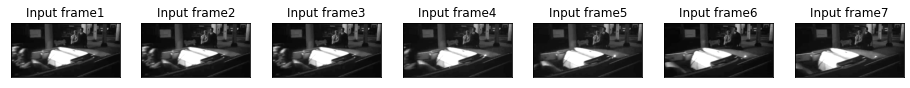

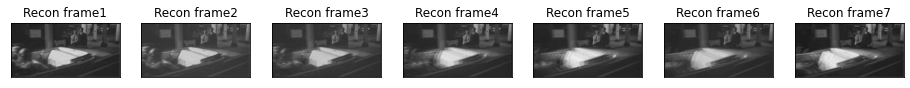

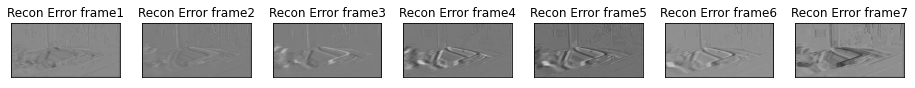

In [12]:
fig1, axs1 = plt.subplots(1, WINDOW_SIZE, figsize=(16, 9))
fig2, axs2 = plt.subplots(1, WINDOW_SIZE, figsize=(16, 9))
fig3, axs3 = plt.subplots(1, WINDOW_SIZE, figsize=(16, 9))
for ind, (a1, a2, a3) in enumerate(zip(axs1, axs2, axs3)):
    recon_error = windowed_frames_batch - recon

    recon_samples = recon[0].squeeze().squeeze().cpu().numpy()

    recon_error_samples = recon_error[0].squeeze().squeeze().cpu().numpy()

    recon_sample = recon_samples[ind]
    recon_error_sample = recon_error_samples[ind]
    inputs_sample = recon_error_sample + recon_sample

    recon_sample = (recon_sample - recon_sample.min()) / (recon_sample.max() - recon_sample.min())
    inputs_sample = (inputs_sample - inputs_sample.min()) / (inputs_sample.max() - inputs_sample.min())

    img1 = a1.imshow(inputs_sample, cmap="gray")
    img2 = a2.imshow(recon_sample, cmap="gray")
    img3 = a3.imshow(recon_error_sample, cmap="gray")

    a1.set_title(f"Input frame{ind+1}")
    a2.set_title(f"Recon frame{ind+1}")
    a3.set_title(f"Recon Error frame{ind+1}")

    a1.get_xaxis().set_visible(False)
    a1.get_yaxis().set_visible(False)
    a2.get_xaxis().set_visible(False)
    a2.get_yaxis().set_visible(False)
    a3.get_xaxis().set_visible(False)
    a3.get_yaxis().set_visible(False)
plt.show()

### Activation Histogram

In [13]:
features_overall_mean_batch_array = (lca.module.trace_weights > 0).cpu().numpy().sum(axis=(1, 2, 3)).squeeze()
v1_overall_mean_batch_array = (code > 0).cpu().numpy().sum(axis=(0, 3, 4)).squeeze()

print(
    code.shape,
    "\n",
    lca.module.trace_weights.shape,
    "\n",
    v1_overall_mean_batch_array.shape,
    "\n",
    features_overall_mean_batch_array,
    "\n",
    features_overall_mean_batch_array.shape,
    "\n",
    code.shape[0] * code.shape[-1] * code.shape[-2],
)

bool_feat_freq_df = pd.DataFrame(columns=["feature", "frequency"])
bool_act_freq_df = pd.DataFrame(columns=["feature", "frequency"])

for n in range(len(v1_overall_mean_batch_array)):
    bool_act_freq_df.loc[n, "feature"] = n + 1
    bool_feat_freq_df.loc[n, "feature"] = n + 1
    bool_feat_freq_df.loc[n, "frequency"] = v1_overall_mean_batch_array[n] / (
        code.shape[0] * code.shape[-1] * code.shape[-2]
    )
    bool_act_freq_df.loc[n, "frequency"] = features_overall_mean_batch_array[n] / (
        lca.module.trace_weights.shape[1] * lca.module.trace_weights.shape[2]
    )

print(bool_feat_freq_df.shape, bool_feat_freq_df["frequency"].max(), bool_feat_freq_df["frequency"].min())

mean_feat_sparsity = bool_feat_freq_df["frequency"].mean()
mean_feat_sparsity_df = bool_feat_freq_df * 0 + mean_feat_sparsity
ax1 = bool_feat_freq_df.plot.bar(x="feature", y="frequency", figsize=(25, 20), legend=False)
mean_feat_sparsity_df.plot(ax=ax1, color="r", title=f"average sparsity: {mean_feat_sparsity}", legend=False)

ax2 = bool_feat_freq_df.sort_values(by=["frequency"], ascending=False).plot.bar(
    x="feature", y="frequency", figsize=(25, 20), legend=False
)
mean_feat_sparsity_df.plot(ax=ax2, color="r", title=f"average sparsity: {mean_feat_sparsity}", legend=False)


mean_act_sparsity = bool_act_freq_df["frequency"].mean()
mean_act_sparsity_df = bool_act_freq_df * 0 + mean_act_sparsity
ax3 = bool_act_freq_df.plot.bar(x="feature", y="frequency", figsize=(25, 20), legend=False)
mean_act_sparsity_df.plot(ax=ax3, color="r", title=f"average sparsity: {mean_act_sparsity}", legend=False)

ax4 = bool_act_freq_df.sort_values(by=["frequency"], ascending=False).plot.bar(
    x="feature", y="frequency", figsize=(25, 20), legend=False
)
mean_act_sparsity_df.plot(ax=ax4, color="r", title=f"average sparsity: {mean_act_sparsity}", legend=False)

NameError: name 'code' is not defined

### Video Feature Dictionary

In [ ]:
T = lca.module.weights.shape[2]
grids = []
for t in range(T):
    grids.append(
        make_grid(
            lca.module.weights[:, :, t],
            int(math.sqrt(lca.module.weights.shape[0])),
            normalize=False,
            scale_each=False,
            pad_value=0.5,
        ).cpu()
    )
print(lca.module.weights.shape)
print(torch.stack(grids).shape)
final_grids = torch.stack(grids).permute(0, 2, 3, 1).cpu().numpy()
imageio.mimwrite(f"../figures/test_link_dict.gif", final_grids, "gif")

### Traces' Feature Grid

In [ ]:
exp_weight_grid = make_feature_grid(lca.module.trace_weights[:, 0].squeeze(-1).moveaxis(1, -1))
weight_grid = make_feature_grid(lca.module.trace_weights.squeeze(-1).squeeze(-1))
# arrange by neuron activation frequency (maximum to minimum)
for i in range(exp_weight_grid.shape[0] % PRINT_FREQ + 10):
    plt.plot(exp_weight_grid[i].cpu().numpy())
    # plt.plot(weight_grid[i].cpu().numpy())
    plt.grid()
    plt.show()
    plt.close()

In [ ]:
%matplotlib inline
# IMP: LOOK AT RECON ERROR PERCENTAGE (recon error/[DIVIDED] by input?)
for i in range(len(trace_recon_error)):
    fig, axs = plt.subplots(1, 2, figsize=(30, 20))
    axs[0].plot((trace_recon_error + trace_recon)[i, 0].cpu().numpy(), linewidth=2, label="input")
    axs[0].plot(trace_recon.cpu().numpy()[i, 0], c="r", linewidth=2, label="reconstruction")
    axs[1].plot(trace_recon_error[i, 0].cpu().numpy(), c="g")
    axs[0].set_title("Trace Input and Reconstruction")
    axs[1].set_title("Trace Reconstruction Error")
    plt.legend(loc="upper right")
    axs[0].set_ylim(trace_recon[i, 0].detach().cpu().min() - 1, trace_recon[i, 0].detach().cpu().max() + 1)
    axs[0].grid()
    axs[1].set_ylim(trace_recon_error[i, 0].detach().cpu().min() - 1, trace_recon_error[i, 0].detach().cpu().max() + 1)
    axs[1].grid()

    plt.show()
    plt.close()

In [ ]:
for i in range(len(trace_recon_error)):
    fig, axs = plt.subplots(1, 3, figsize=(30, 20))
    axs[0].plot((trace_recon_error + trace_recon)[i, 0].cpu().numpy())
    axs[1].plot(trace_recon.cpu().numpy()[i, 0])
    axs[2].plot(trace_recon_error[i, 0].cpu().numpy())
    axs[0].set_title("Trace Input")
    axs[1].set_title("Trace Reconstruction")
    axs[2].set_title("Trace Reconstruction Error")

    for ax in axs:
        ax.set_ylim(-3, 3)
        ax.grid()

    plt.show()
    plt.close()

# LCA Validation

### Setup mouse V1 responses over time

In [14]:
mean_dff = pd.DataFrame()
max_dff = pd.DataFrame()
TOTAL_COLUMNS = 2
TOTAL_REPS = 1400
REPETITIONS = 10
exps_cells = []
column_exp = []
column_cell = []
complete_column_cell_exp_list = []
for column in dff_df.columns[7:]:
    complete_column_cell_exp_list.append(column)
    column_cell.append(column.split("_")[0])
    column_exp.append(column.split("_")[1])
new_column_exp = np.unique(column_exp)
print("Average cell count per experiment:")
print(
    len(np.unique(column_cell)) // len(np.unique(column_exp)),
    "=",
    len(np.unique(column_cell)),
    "//",
    len(np.unique(column_exp)),
)
for exp_index in range(15, 22):
    for cell_exp in complete_column_cell_exp_list:
        if str(cell_exp).endswith(new_column_exp[exp_index]):
            exps_cells.append(cell_exp)
print("total cells:", len(exps_cells))
dff_exps = dff_df[["frame", "repeat", "stimulus", "session_type", *exps_cells]]
dff_exps_movie3_list = []
for exp_cell in exps_cells:
    if dff_exps[dff_exps["stimulus"] == "natural_movie_three"][exp_cell].values.all() == False:
        dff_exp_movie_reps = torch.split(
            torch.tensor(
                dff_exps[["stimulus", exp_cell]]
                .where(dff_exps["stimulus"] == "natural_movie_three")
                .dropna()[exp_cell]
                .values
            ),
            NUM_INPUT_REP,
            0,
        )
        # dff_exp_cell = dff_exps[["stimulus", exp_cell]].where(dff_exps["stimulus"] == "natural_movie_three").dropna()
        for ind, dff_exp_sample in enumerate(dff_exp_movie_reps):
            # ind == 0 is only using the first repetition per cell
            # if ind == 0: dff_exps_movie3_list.append(dff_exp_sample)
            dff_exps_movie3_list.append(dff_exp_sample)
dff_exps_movie3 = torch.stack(dff_exps_movie3_list)
print(dff_exps_movie3.shape, len(dff_exps_movie3))
for cell_ind in range(0, TOTAL_REPS, REPETITIONS):
    grey_df = pd.concat(
        [
            pd.DataFrame(
                dff_exps_movie3[
                    cell_ind : cell_ind + REPETITIONS, : dff_exps_movie3.shape[1] // SPLITTED_BATCHES
                ].numpy()
            )
        ]
    )
    max_dff = pd.concat([max_dff, grey_df.max(axis=0).to_frame()], axis=1)
    mean_dff = pd.concat([mean_dff, grey_df.mean().to_frame()], axis=1)

Average cell count per experiment:
247 = 12380 // 50
total cells: 1220
torch.Size([5110, 3600]) 5110


In [18]:
max_dff_arr.shape, mean_dff_arr.shape

((140, 300), (140, 300))

In [16]:
max_dff_arr = np.array(max_dff.T)
# max_dff.plot(
#     subplots=True,
#     layout=(int(TOTAL_REPS // (TOTAL_COLUMNS * REPETITIONS)), TOTAL_COLUMNS),
#     figsize=(60, 30),
#     color="red",
# )

In [17]:
mean_dff_arr = np.array(mean_dff.T)
# mean_dff.plot(
#     subplots=True,
#     layout=(int(TOTAL_REPS // (TOTAL_COLUMNS * REPETITIONS)), TOTAL_COLUMNS),
#     figsize=(60, 30),
#     color="blue",
# )

### Setup LCA Activations over time (trace_act_usage)

In [19]:
trace_act_usage = torch.zeros(
    (
        len(splitted_wt[: len(splitted_wt) // SPLITTED_BATCHES]) * BATCH_SIZE,
        lca.module.trace_weights.shape[0],
        torch_wf.shape[-1] // 4,
        torch_wf.shape[-2],
    ),
    device="cpu",
)

for batch_ind in range(len(splitted_wt) // SPLITTED_BATCHES):
    trace_act_usage[batch_ind * BATCH_SIZE : batch_ind * BATCH_SIZE + BATCH_SIZE] = torch.load(
        f"../data/traces_act_usage/lca_chckpnt_{batch_ind}.pt"
    )

### Setup LCA Neurons' States over time (lca_neuron_states)

In [20]:
lca_neuron_states = torch.zeros(
    (
        len(splitted_wt[: len(splitted_wt) // SPLITTED_BATCHES]) * BATCH_SIZE,
        lca.module.trace_weights.shape[0],
        torch_wf.shape[-1] // 4,
        torch_wf.shape[-2],
    ),
    device="cpu",
)

for batch_ind in range(len(splitted_wt) // SPLITTED_BATCHES):
    lca_neuron_states[batch_ind * BATCH_SIZE : batch_ind * BATCH_SIZE + BATCH_SIZE] = torch.load(
        f"../data/traces_states/lca_chckpnt_{batch_ind}.pt"
    )

### Debugging mean_dff & trace_act_usage specific shapes

In [ ]:
mean_dff_arr = np.array(mean_dff)
# print(trace_act_usage.shape)
print(
    mean_dff_arr.flatten().max(),
    mean_dff_arr.flatten().min(),
    mean_dff_arr.flatten().mean(),
    mean_dff_arr.flatten().std(),
)

trace_act_usage.flatten().flatten().flatten().max(), trace_act_usage.flatten().flatten().flatten().min(), trace_act_usage.flatten().flatten().flatten().mean(), trace_act_usage.flatten().flatten().flatten().std()

In [ ]:
# print(trace_act_usage.max(-3, -2, -1).values)
# max_act_usage = trace_act_usage.max(-3, -2, -1)
# plt.scatter(range(140), max_act_usage.values.cpu().numpy())
print(trace_act_usage[:, feat_ind].shape, trace_act_usage.shape)
print(feat_ind, trace_act_usage[:, feat_ind].mean(0).shape, trace_act_usage[:, feat_ind].mean((-2, -1)).shape)
plt.plot(range(len(trace_act_usage[:, feat_ind].mean((-2, -1)))), trace_act_usage[:, 1].mean((-2, -1)))

# fig, axs = plt.subplots(70, 2, figsize=(20, 30))
# for feat_ind in range(trace_act_usage.shape[1]):
#     max_act_usage = trace_act_usage[:, feat_ind].max((-2, -1))
#     if feat_ind < trace_act_usage.shape[1] // 2:
#         axs[feat_ind, 0].plot(
# 			range(360), max_act_usage.values.cpu().numpy())
#     else:
#         axs[feat_ind - (trace_act_usage.shape[1] // 2), 1].plot(
# 			range(360), max_act_usage.values.cpu().numpy())
# plt.show()

In [ ]:
reshaped_trace_act_usage = trace_act_usage.reshape(
    (len(trace_act_usage), trace_act_usage.shape[1], trace_act_usage.shape[-1] * trace_act_usage.shape[-2])
)

print(
    feat_ind,
    "\n",
    reshaped_trace_act_usage.shape,
    "\n",
    reshaped_trace_act_usage[:, feat_ind].shape,
    "\n",
    reshaped_trace_act_usage[:, feat_ind].max(-1).values,
    len(reshaped_trace_act_usage[:, feat_ind].max(-1).values),
)

### Scaling Methods

In [21]:
max_dff_arr /= max(map(max, np.absolute(max_dff_arr)))
np.argwhere(max_dff_arr == max(map(max, np.absolute(max_dff_arr)))), max(map(max, np.absolute(max_dff_arr)))

(array([[  1,  20],
        [ 21, 179],
        [ 42,   2],
        [ 44, 100],
        [ 47,   0],
        [ 52, 111],
        [ 67,  24],
        [ 74,  63],
        [ 79,  39],
        [ 86,  77],
        [ 97,  39],
        [ 98, 179],
        [113,  62],
        [120, 156],
        [129, 161],
        [134, 137]]),
 1.0)

In [22]:
mean_dff_arr /= max(map(max, np.absolute(mean_dff_arr)))
np.argwhere(mean_dff_arr == max(map(max, np.absolute(mean_dff_arr)))), max(map(max, np.absolute(mean_dff_arr)))

(array([[ 21, 174]]), 1.0)

In [23]:
lca_neuron_states /= lca_neuron_states.max()
torch.argwhere(lca_neuron_states == lca_neuron_states.max()), lca_neuron_states.max()

(tensor([[222,  73,  18, 264]]), tensor(1.))

In [24]:
trace_act_usage /= trace_act_usage.max()
torch.argwhere(trace_act_usage == trace_act_usage.max()), trace_act_usage.max()

(tensor([[222,  73,  18, 264]]), tensor(1.))

In [ ]:
reshaped_trace_act_usage = trace_act_usage.reshape(
    (len(trace_act_usage), trace_act_usage.shape[1], trace_act_usage.shape[-1] * trace_act_usage.shape[-2])
)
reshaped_lca_neuron_states = lca_neuron_states.reshape(
    (len(lca_neuron_states), lca_neuron_states.shape[1], lca_neuron_states.shape[-1] * lca_neuron_states.shape[-2])
)

In [ ]:
reshaped_trace_act_usage /= reshaped_trace_act_usage.max()
torch.argwhere(reshaped_trace_act_usage == reshaped_trace_act_usage.max()), reshaped_trace_act_usage.max()

reshaped_lca_neuron_states /= reshaped_lca_neuron_states.max()
torch.argwhere(reshaped_lca_neuron_states == reshaped_lca_neuron_states.max()), reshaped_lca_neuron_states.max()

### EYEBALL TESTING (INDIVIDUAL COMPARISONS)

##### MEAN POOLING

In [ ]:
mean_fig, mean_axs = plt.subplots(70, 4, figsize=(60, 80))

plt.setp(
    mean_axs,
    ylim=(
        trace_act_usage.mean((-2, -1)).min(0).values.min(0).values - 0.05,
        trace_act_usage.mean((-2, -1)).max(0).values.max(0).values + 0.05,
    ),
)

for feat_ind in range(trace_act_usage.shape[1]):
    # mean_act_usage = trace_act_usage[:, feat_ind].mean(-2, -1)
    if feat_ind < trace_act_usage.shape[1] // 2:
        mean_axs[feat_ind, 2].plot(mean_dff_arr[feat_ind], c="red")
        mean_axs[feat_ind, 0].plot(
            range(len(trace_act_usage[:, feat_ind].mean((-2, -1)))), trace_act_usage[:, feat_ind].mean((-2, -1))
        )
    else:
        mean_axs[feat_ind - (trace_act_usage.shape[1] // 2), 3].plot(mean_dff_arr[feat_ind], c="red")
        mean_axs[feat_ind - (trace_act_usage.shape[1] // 2), 1].plot(
            range(len(trace_act_usage[:, feat_ind].mean((-2, -1)))), trace_act_usage[:, feat_ind].mean((-2, -1))
        )
# plt.title("Individual Comparisons between Average-Pooled LCA Neuron Activations and Mice V1 Responses", fontsize=50)
# plt.xlabel("Frame", fontsize=50)
# plt.ylabel("Value", fontsize=50)
# plt.xticks(fontsize=50)
# plt.yticks(fontsize=50)
plt.tight_layout()
plt.show()

##### MAX POOLING

In [ ]:
max_fig, max_axs = plt.subplots(70, 4, figsize=(60, 80))

reshaped_trace_act_usage = trace_act_usage.reshape(
    (len(trace_act_usage), trace_act_usage.shape[1], trace_act_usage.shape[-1] * trace_act_usage.shape[-2])
)

plt.setp(
    max_axs,
    ylim=(
        reshaped_trace_act_usage.max(-1).values.min(0).values.min(0).values - 0.05,
        reshaped_trace_act_usage.max(-1).values.max(0).values.max(0).values + 0.05,
    ),
)

for feat_ind in range(reshaped_trace_act_usage.shape[1]):
    if feat_ind < reshaped_trace_act_usage.shape[1] // 2:
        max_axs[feat_ind, 2].plot(mean_dff_arr[feat_ind], c="red")
        max_axs[feat_ind, 0].plot(
            range(len(reshaped_trace_act_usage[:, feat_ind].max(-1).values)),
            reshaped_trace_act_usage[:, feat_ind].max(-1).values,
        )
    else:
        max_axs[feat_ind - (reshaped_trace_act_usage.shape[1] // 2), 3].plot(mean_dff_arr[feat_ind], c="red")
        max_axs[feat_ind - (reshaped_trace_act_usage.shape[1] // 2), 1].plot(
            range(len(reshaped_trace_act_usage[:, feat_ind].max(-1).values)),
            reshaped_trace_act_usage[:, feat_ind].max(-1).values,
        )
# plt.title("Individual Comparisons between Max-Pooled LCA Neuron Activations and Mice V1 Responses", fontsize=50)
# plt.xlabel("Frame", fontsize=50)
# plt.ylabel("Value", fontsize=50)
# plt.xticks(fontsize=50)
# plt.yticks(fontsize=50)
plt.tight_layout()
plt.show()

##### SUM POOLING

In [ ]:
sum_fig, sum_axs = plt.subplots(70, 4, figsize=(60, 80))

plt.setp(
    sum_axs,
    ylim=(
        trace_act_usage.sum((-2, -1)).min(0).values.min(0).values - 0.05,
        trace_act_usage.sum((-2, -1)).max(0).values.max(0).values + 0.05,
    ),
)

for feat_ind in range(trace_act_usage.shape[1]):
    # sum_act_usage = trace_act_usage[:, feat_ind].sum(-2, -1)
    if feat_ind < trace_act_usage.shape[1] // 2:
        sum_axs[feat_ind, 2].plot(mean_dff_arr[feat_ind], c="red")
        sum_axs[feat_ind, 0].plot(
            range(len(trace_act_usage[:, feat_ind].sum((-2, -1)))), trace_act_usage[:, feat_ind].sum((-2, -1))
        )
    else:
        sum_axs[feat_ind - (trace_act_usage.shape[1] // 2), 3].plot(mean_dff_arr[feat_ind], c="red")
        sum_axs[feat_ind - (trace_act_usage.shape[1] // 2), 1].plot(
            range(len(trace_act_usage[:, feat_ind].sum((-2, -1)))), trace_act_usage[:, feat_ind].sum((-2, -1))
        )
# plt.title("Individual Comparisons between Sum-Pooled LCA Neuron Activations and Mice V1 Responses", fontsize=50)
# plt.xlabel("Frame", fontsize=50)
# plt.ylabel("Value", fontsize=50)
# plt.xticks(fontsize=50)
# plt.yticks(fontsize=50)
plt.tight_layout()
plt.show()

### EYEBALL TESTING (SINGLE FIGURE COMPARISON)

##### MEAN POOLING

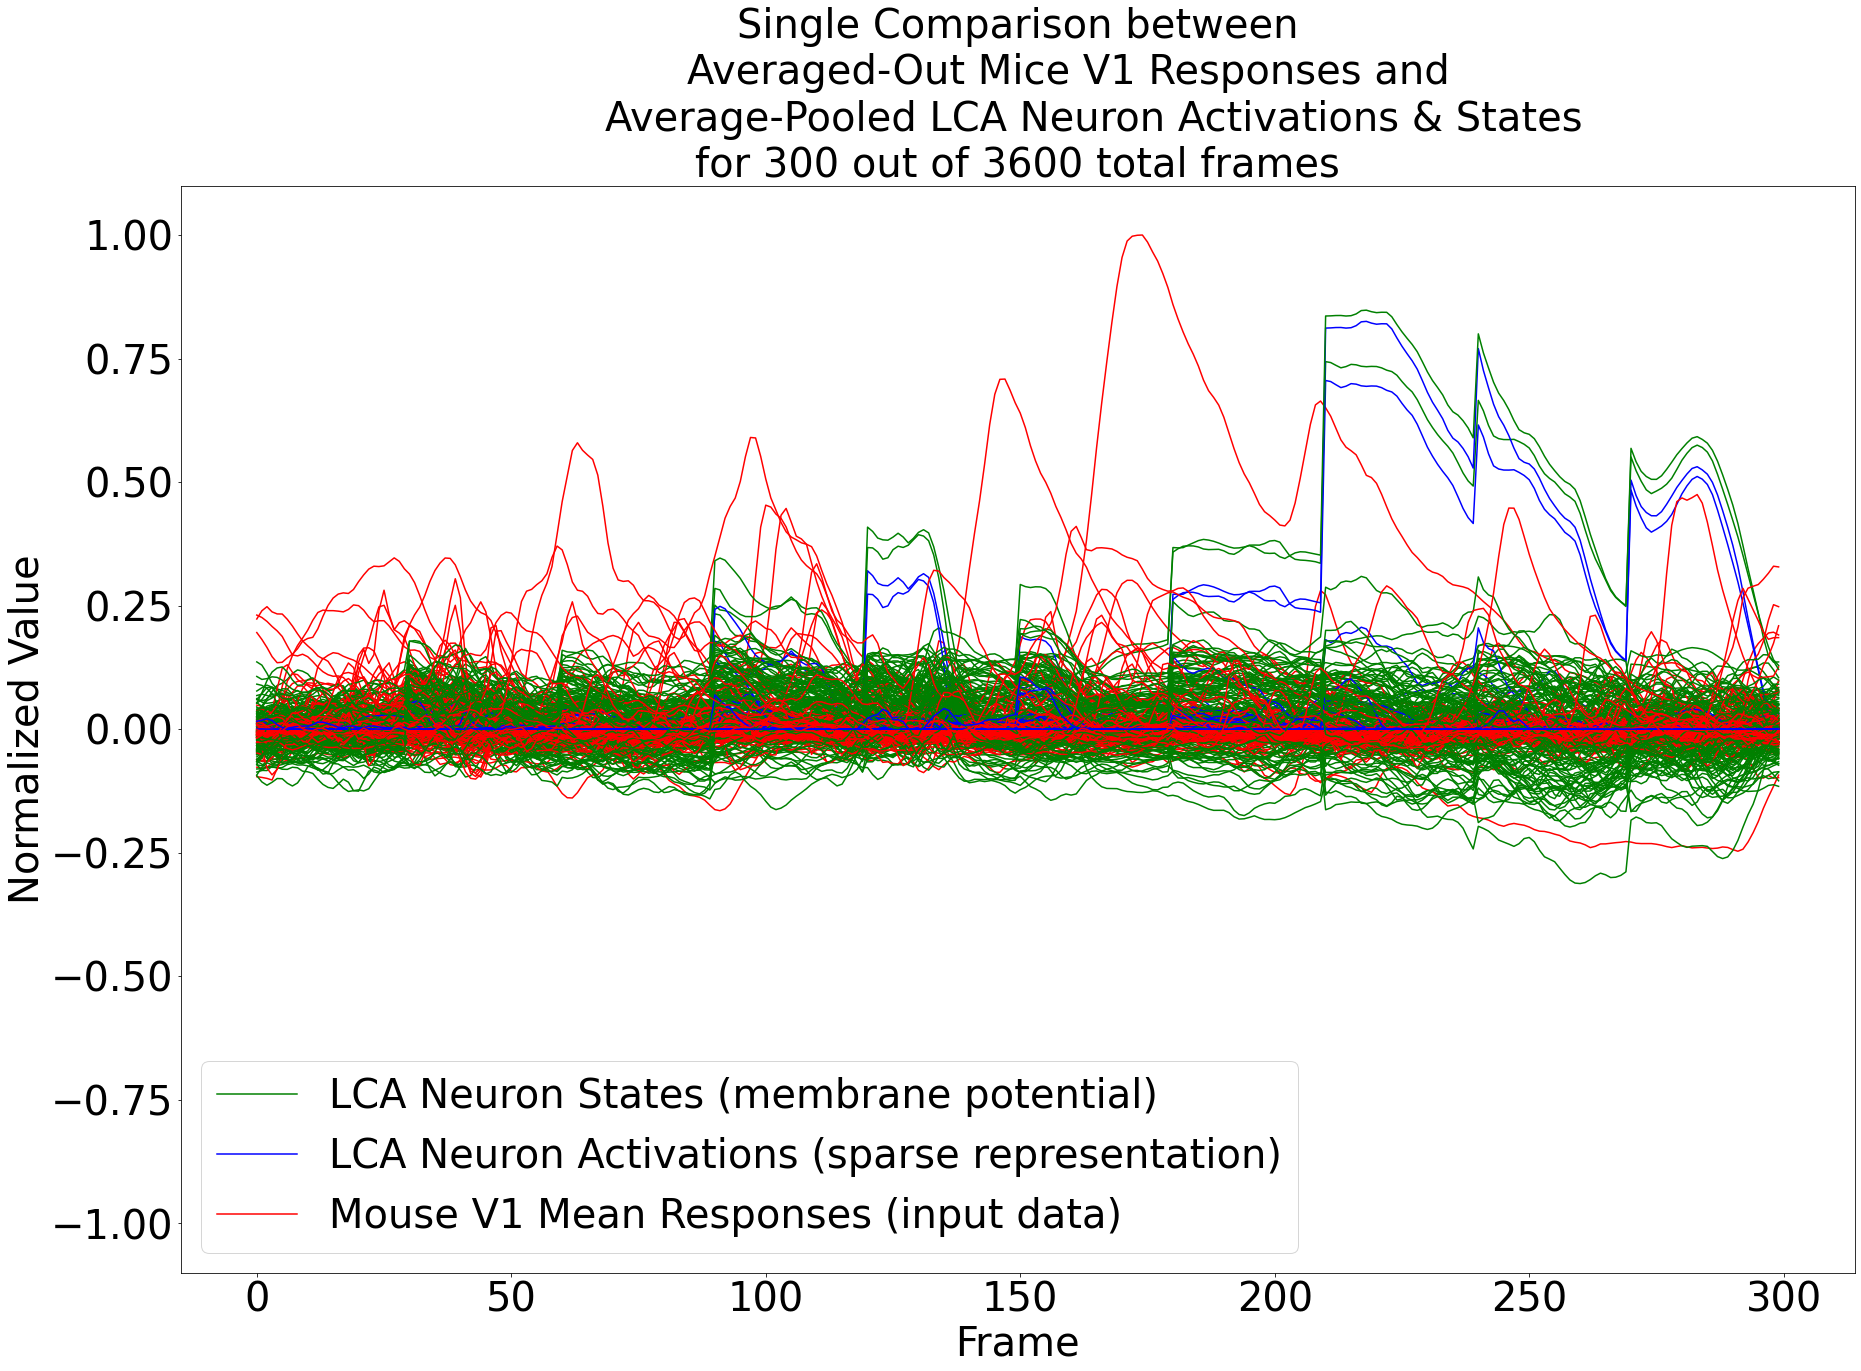

In [25]:
mean_fig, mean_axs = plt.subplots(1, 1, figsize=(30, 20))

if int(trace_act_usage.max()) == int(max(map(max, np.absolute(mean_dff_arr)))):
    plt.setp(mean_axs, ylim=(-1.1, 1.1))
elif int(trace_act_usage.max()) > int(max(map(max, np.absolute(mean_dff_arr)))):
    plt.setp(mean_axs, ylim=(-1.1, trace_act_usage.max()))
else:
    plt.setp(mean_axs, ylim=(-1.1, max(map(max, np.absolute(mean_dff_arr)))))


for feat_ind in range(trace_act_usage.shape[1]):
    # if np.absolute(mean_dff_arr[feat_ind]).max(0) != 1:
    #     mean_dff_arr[feat_ind] /= np.absolute(mean_dff_arr[feat_ind]).max(0)
    # if torch.max(torch.abs(trace_act_usage[:, feat_ind].mean((-2, -1))),axis=0).values.max(0).values > 1:
    #     trace_act_usage[:, feat_ind] /= torch.max(torch.abs(trace_act_usage[:, feat_ind].mean((-2, -1))),axis=0).values

    if feat_ind == 0:
        mean_axs.plot(
            range(len(lca_neuron_states[:, feat_ind].mean((-2, -1)))),
            lca_neuron_states[:, feat_ind].mean((-2, -1)),
            c="green",
            label="LCA Neuron States (membrane potential)",
        )
        mean_axs.plot(
            range(len(trace_act_usage[:, feat_ind].mean((-2, -1)))),
            trace_act_usage[:, feat_ind].mean((-2, -1)),
            c="blue",
            label="LCA Neuron Activations (sparse representation)",
        )
        mean_axs.plot(mean_dff_arr[feat_ind], c="red", label="Mouse V1 Mean Responses (input data)")
    else:
        mean_axs.plot(
            range(len(trace_act_usage[:, feat_ind].mean((-2, -1)))),
            trace_act_usage[:, feat_ind].mean((-2, -1)),
            c="blue",
        )
        mean_axs.plot(
            range(len(lca_neuron_states[:, feat_ind].mean((-2, -1)))),
            lca_neuron_states[:, feat_ind].mean((-2, -1)),
            c="green",
        )
        mean_axs.plot(mean_dff_arr[feat_ind], c="red")

plt.ylabel("Normalized Value", fontsize=40)
plt.xlabel("Frame", fontsize=40)
plt.legend(prop={"size": 40})
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
plt.title(
    f"Single Comparison between\n\
        Averaged-Out Mice V1 Responses and\n\
            Average-Pooled LCA Neuron Activations & States\n\
for {INPUT_CROP_SIZE * BATCH_SIZE} out of {len(movie)} total frames",
    fontsize=40,
)
plt.show()

##### MAX POOLING

In [ ]:
# reshaped_trace_act_usage = trace_act_usage.reshape(
#     (len(trace_act_usage), trace_act_usage.shape[1], trace_act_usage.shape[-1] * trace_act_usage.shape[-2])
# )

# reshaped_trace_act_usage /= reshaped_trace_act_usage.max()

if int(trace_act_usage.max()) == int(max(map(max, np.absolute(mean_dff_arr)))):
    plt.setp(mean_axs, ylim=(-1.1, 1.1))
elif int(trace_act_usage.max()) > int(max(map(max, np.absolute(mean_dff_arr)))):
    plt.setp(mean_axs, ylim=(-1.1, trace_act_usage.max()))
else:
    plt.setp(mean_axs, ylim=(-1.1, max(map(max, np.absolute(mean_dff_arr)))))

max_fig, max_axs = plt.subplots(1, 1, figsize=(30, 20))
# plt.setp(max_axs, ylim=(-0.5,1.1))

for feat_ind in range(reshaped_trace_act_usage.shape[1]):
    if feat_ind == 0:
        max_axs.plot(
            range(len(reshaped_trace_act_usage[:, feat_ind].max(-1).values)),
            reshaped_trace_act_usage[:, feat_ind].max(-1).values,
            c="blue",
            label="LCA Neuron Activations (sparse representation)",
        )
        max_axs.plot(
            range(len(reshaped_lca_neuron_states[:, feat_ind].max(-1).values)),
            reshaped_lca_neuron_states[:, feat_ind].max(-1).values,
            c="green",
            label="LCA Neuron States (membrane potential)",
        )
        max_axs.plot(max_dff_arr[feat_ind], c="red", label="Mouse V1 Max Responses (input data)")
        max_axs.plot(mean_dff_arr[feat_ind], c="white", label="Mouse V1 Mean Responses (input data)")
        # print(len(reshaped_trace_act_usage[:, feat_ind].max(-1).values), reshaped_trace_act_usage[:, feat_ind].shape, reshaped_trace_act_usage.shape)
    else:
        max_axs.plot(
            range(len(reshaped_trace_act_usage[:, feat_ind].max(-1).values)),
            reshaped_trace_act_usage[:, feat_ind].max(-1).values,
            c="blue",
        )
        max_axs.plot(
            range(len(reshaped_lca_neuron_states[:, feat_ind].max(-1).values)),
            reshaped_lca_neuron_states[:, feat_ind].max(-1).values,
            c="green",
        )
        max_axs.plot(max_dff_arr[feat_ind], c="red")
        max_axs.plot(mean_dff_arr[feat_ind], c="white")


plt.ylabel("Normalized Value", fontsize=50)
plt.xlabel("Frame", fontsize=50)
plt.legend(prop={"size": 40})
plt.xticks(fontsize=50)
plt.yticks(fontsize=50)
plt.title(
    f"Single Comparison between\n\
        the Mice V1 Max-Pooled Responses &\n\
        the Max-Pooled LCA Neuron Activations & States\n\
for {INPUT_CROP_SIZE * BATCH_SIZE} out of {len(movie)} total frames",
    fontsize=50,
)
plt.show()

##### SUM POOLING

In [ ]:
sum_fig, sum_axs = plt.subplots(1, 1, figsize=(30, 20))

plt.setp(
    sum_axs,
    ylim=(
        trace_act_usage.sum((-2, -1)).min(0).values.min(0).values - 0.05,
        trace_act_usage.sum((-2, -1)).max(0).values.max(0).values + 0.05,
    ),
)

for feat_ind in range(trace_act_usage.shape[1]):
    if feat_ind == 0:
        sum_axs.plot(
            range(len(trace_act_usage[:, feat_ind].sum((-2, -1)))),
            trace_act_usage[:, feat_ind].sum((-2, -1)),
            c="blue",
            label="LCA Neuron Activations",
        )
        sum_axs.plot(mean_dff_arr[feat_ind], c="red", label="Mouse V1 Responses")
    else:
        sum_axs.plot(
            range(len(trace_act_usage[:, feat_ind].sum((-2, -1)))),
            trace_act_usage[:, feat_ind].sum((-2, -1)),
            c="blue",
        )
        sum_axs.plot(mean_dff_arr[feat_ind], c="red")

plt.title("Single Comparison between Sum-Pooled LCA Neuron Activations and Mice V1 Responses", fontsize=50)
plt.xlabel("Frame", fontsize=50)
plt.ylabel("Value", fontsize=50)
plt.xticks(fontsize=50)
plt.yticks(fontsize=50)
plt.tight_layout()
plt.legend()
plt.show()

### Debugging for Post-processing

##### LCA Neuron Activations as reconstructed movie feature

In [ ]:
%matplotlib inline

# print(len(acts_list))
# for act_ind, act_sample in enumerate (acts_list):
# 	if act_ind == 0: print(act_sample.shape, act_sample)

new_acts_list = []
for acts_sample in acts_list:
    acts_sample = acts_sample.cpu()
    new_acts_list.append(acts_sample.cpu())

t_acts = torch.stack(new_acts_list).to("cpu")
t_acts = torch.reshape(
    t_acts.squeeze(), (t_acts.shape[0] * t_acts.shape[1], t_acts.shape[2], t_acts.shape[-2], t_acts.shape[-1])
)
print(t_acts.shape)
for i in range(t_acts.shape[1]):
    if not os.path.exists(f"../reports/images_acts/cell{i+1}lca/"):
        os.makedirs(f"../reports/images_acts/cell{i+1}lca/")
    act_imgs = []

    for j in range(t_acts.shape[0]):
        save_image(t_acts[j, i, :, :], f"../reports/images_acts/cell{i+1}lca/img{j}.png")

    for act_path in sorted(glob.glob(f"../reports/images_acts/cell{i+1}lca/*.png")):
        # print(img_path, imageio.imread(img_path).shape)
        act_imgs.append(imageio.imread(act_path))

    imageio.mimsave(f"../reports/movies_acts/movie_lca_cell_{i+1}.gif", act_imgs)
plt.show()

##### Non-capped LCA Neuron Activations

In [ ]:
%matplotlib inline

new_trace_recon_list = []
for trace_recon_sample in trace_recon_list:
    new_trace_recon_list.append(trace_recon_sample.detach())

t_trace_recons = torch.stack(new_trace_recon_list)
t_trace_recons = torch.reshape(
    t_trace_recons,
    (t_trace_recons.shape[0] * t_trace_recons.shape[1], t_trace_recons.shape[-2], t_trace_recons.shape[-1]),
)
print(t_trace_recons.shape)

fig, axs = plt.subplots(50, 2, figsize=(20, 30))
for i in range(t_trace_recons.shape[-2]):
    plot_trace_recon_list = []
    for j in range(t_trace_recons.shape[0]):
        if j == 0:
            for k in range(t_trace_recons.shape[-1]):
                plot_trace_recon_list.append(t_trace_recons[j, i, k].cpu().numpy())
        else:
            plot_trace_recon_list.append(t_trace_recons[j, i, -1].cpu().numpy())
    t_plot_trace_recons = np.array(plot_trace_recon_list)
    if i < t_trace_recons.shape[-2] // 2:
        axs[i, 0].plot(t_plot_trace_recons)
    else:
        axs[i - (t_trace_recons.shape[-2] // 2), 1].plot(t_plot_trace_recons)
plt.show()

# Correlations Scores

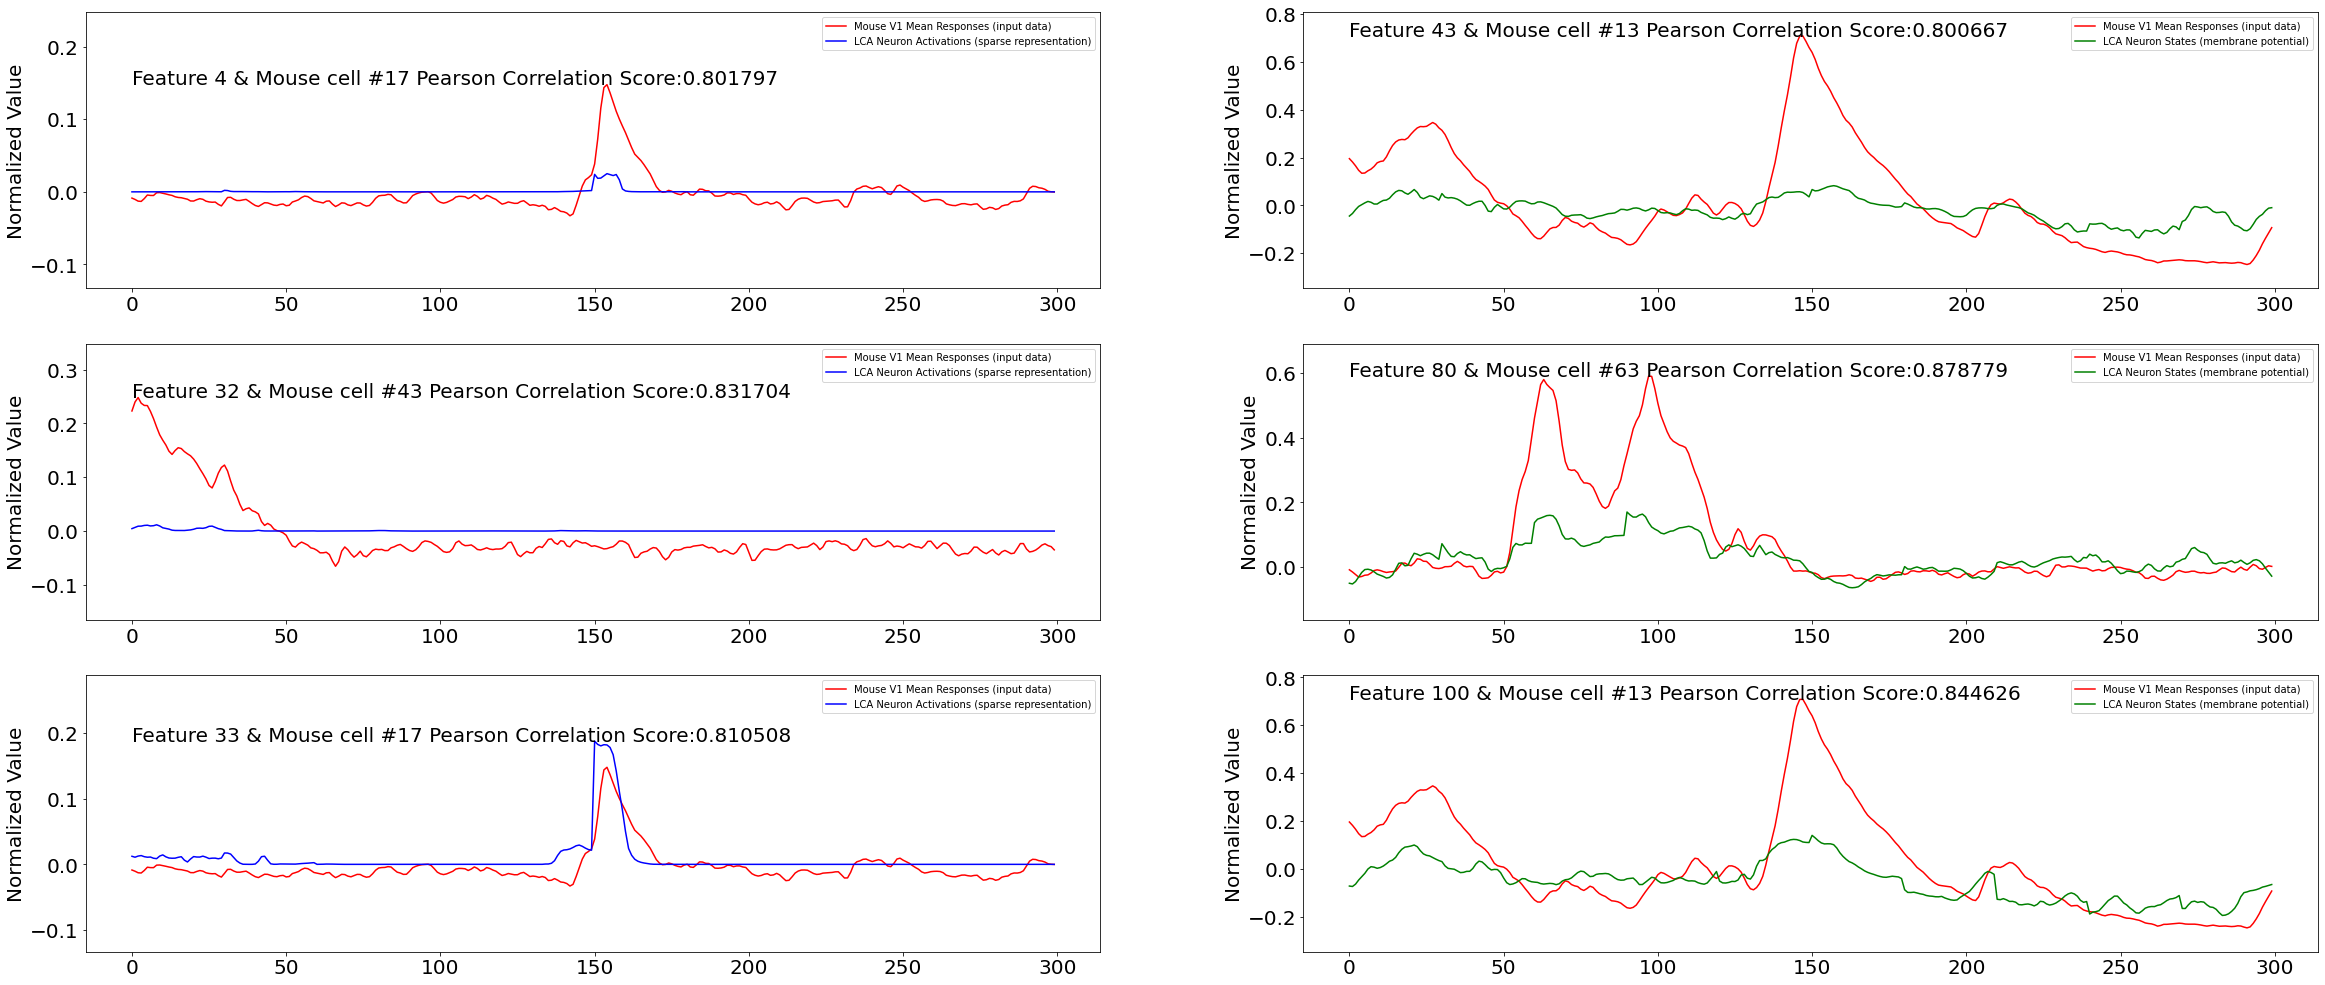

In [110]:
import scipy.stats as ss


# corr_fig, corr_axs = plt.subplots(10, 2, sharex=True, sharey=True, figsize=(30, 50))

states_counter = 0
acts_counter = -1
feat_corr = []

for feat_ind in range(lca.module.trace_weights.shape[0]):
    a_corr_scores_per_lca_feat = []
    s_corr_scores_per_lca_feat = []
    mean_trace_act_usage_feat = trace_act_usage[:, feat_ind].mean((-2, -1))
    mean_lca_neuron_states_feat = lca_neuron_states[:, feat_ind].mean((-2, -1))

    for mean_dff_arr_feat_index, mean_dff_arr_feature in enumerate(mean_dff_arr):
        stat_a, _ = ss.pearsonr(mean_trace_act_usage_feat, mean_dff_arr_feature)
        stat_s, _ = ss.pearsonr(mean_lca_neuron_states_feat, mean_dff_arr_feature)
        # print(ss.pearsonr(mean_lca_neuron_states_feat, mean_dff_arr_feature)[0])
        a_corr_scores_per_lca_feat.append(ss.pearsonr(mean_trace_act_usage_feat, mean_dff_arr_feature)[0])
        s_corr_scores_per_lca_feat.append(ss.pearsonr(mean_lca_neuron_states_feat, mean_dff_arr_feature)[0])

        if stat_s >= 0.8:
            states_counter += 2
            if states_counter <= 20:
                corr_axs = plt.subplot(10, 2, states_counter)
                corr_axs.plot(
                    range(len(mean_dff_arr_feature)),
                    mean_dff_arr_feature,
                    c="red",
                    label="Mouse V1 Mean Responses (input data)",
                )
                corr_axs.plot(
                    range(len(mean_lca_neuron_states_feat)),
                    mean_lca_neuron_states_feat,
                    c="green",
                    label="LCA Neuron States (membrane potential)",
                )
                # print('state corr: ', feat_ind, mean_dff_arr_feat_index, stat_s)
                if mean_dff_arr_feature.max() > mean_lca_neuron_states_feat.max():
                    if mean_dff_arr_feature.min() < mean_lca_neuron_states_feat.min():
                        corr_axs.set_ylim([mean_dff_arr_feature.min() - 0.1, mean_dff_arr_feature.max() + 0.1])
                        corr_axs.annotate(
                            f"Feature {feat_ind+1} & Mouse cell #{mean_dff_arr_feat_index+1} Pearson Correlation Score:{stat_s:6f}",
                            xy=(0, mean_dff_arr_feature.max()),
                            size=20,
                        )
                    else:
                        corr_axs.set_ylim([mean_lca_neuron_states_feat.min() - 0.1, mean_dff_arr_feature.max() + 0.1])
                        corr_axs.annotate(
                            f"Feature {feat_ind+1} & Mouse cell #{mean_dff_arr_feat_index+1} Pearson Correlation Score:{stat_s:6f}",
                            xy=(0, mean_dff_arr_feature.max()),
                            size=20,
                        )
                else:
                    if mean_dff_arr_feature.min() < mean_lca_neuron_states_feat.min():
                        corr_axs.set_ylim([mean_dff_arr_feature.min() - 0.1, mean_lca_neuron_states_feat.max() + 0.1])
                        corr_axs.annotate(
                            f"Feature {feat_ind+1} & Mouse cell #{mean_dff_arr_feat_index+1} Pearson Correlation Score:{stat_s:6f}",
                            xy=(0, mean_lca_neuron_states_feat.max()),
                            size=20,
                        )
                    else:
                        corr_axs.set_ylim(
                            [mean_lca_neuron_states_feat.min() - 0.1, mean_lca_neuron_states_feat.max() + 0.1]
                        )
                        corr_axs.annotate(
                            f"Feature {feat_ind+1} & Mouse cell #{mean_dff_arr_feat_index+1} Pearson Correlation Score:{stat_s:6f}",
                            xy=(0, mean_lca_neuron_states_feat.max()),
                            size=20,
                        )
                corr_axs.set_ylabel("Normalized Value", fontsize=20)
                corr_axs.yaxis.set_tick_params(labelsize=20)
                corr_axs.xaxis.set_tick_params(labelsize=20)
                corr_axs.legend(prop={"size": 10})

        if stat_a >= 0.8:
            acts_counter += 2
            if acts_counter <= 20:
                corr_axs = plt.subplot(10, 2, acts_counter)
                corr_axs.plot(
                    range(len(mean_dff_arr_feature)),
                    mean_dff_arr_feature,
                    c="red",
                    label="Mouse V1 Mean Responses (input data)",
                )
                corr_axs.plot(
                    range(len(mean_trace_act_usage_feat)),
                    mean_trace_act_usage_feat,
                    c="blue",
                    label="LCA Neuron Activations (sparse representation)",
                )
                # print('acts corr:', feat_ind, mean_dff_arr_feat_index, stat_a)
                if mean_dff_arr_feature.max() > mean_trace_act_usage_feat.max():
                    if mean_dff_arr_feature.min() < mean_trace_act_usage_feat.min():
                        corr_axs.set_ylim([mean_dff_arr_feature.min() - 0.1, mean_dff_arr_feature.max() + 0.1])
                        corr_axs.annotate(
                            f"Feature {feat_ind+1} & Mouse cell #{mean_dff_arr_feat_index+1} Pearson Correlation Score:{stat_a:6f}",
                            xy=(0, mean_dff_arr_feature.max()),
                            size=20,
                        )
                    else:
                        corr_axs.set_ylim([mean_trace_act_usage_feat.min() - 0.1, mean_dff_arr_feature.max() + 0.1])
                        corr_axs.annotate(
                            f"Feature {feat_ind+1} & Mouse cell #{mean_dff_arr_feat_index+1} Pearson Correlation Score:{stat_a:6f}",
                            xy=(0, mean_dff_arr_feature.max()),
                            size=20,
                        )
                else:
                    if mean_dff_arr_feature.min() < mean_trace_act_usage_feat.min():
                        corr_axs.set_ylim([mean_dff_arr_feature.min() - 0.1, mean_trace_act_usage_feat.max() + 0.1])
                        corr_axs.annotate(
                            f"Feature {feat_ind+1} & Mouse cell #{mean_dff_arr_feat_index+1} Pearson Correlation Score:{stat_a:6f}",
                            xy=(0, mean_trace_act_usage_feat.max()),
                            size=20,
                        )
                    else:
                        corr_axs.set_ylim(
                            [mean_trace_act_usage_feat.min() - 0.1, mean_trace_act_usage_feat.max() + 0.1]
                        )
                        corr_axs.annotate(
                            f"Feature {feat_ind+1} & Mouse cell #{mean_dff_arr_feat_index+1} Pearson Correlation Score:{stat_a:6f}",
                            xy=(0, mean_trace_act_usage_feat.max()),
                            size=20,
                        )
                corr_axs.set_ylabel("Normalized Value", fontsize=20)
                corr_axs.xaxis.set_tick_params(labelsize=20)
                corr_axs.yaxis.set_tick_params(labelsize=20)
                corr_axs.legend(prop={"size": 10})

    feat_corr.append((s_corr_scores_per_lca_feat, t_corr_scores_per_lca_feat))

# print(states_counter // 2, acts_counter // 2)
plt.gcf().set_size_inches(40, 60)
plt.show()

In [ ]:
for feature_index, (state_corr_scores_per_lca_feat, act_corr_scores_per_lca_feat) in enumerate(np.array(feat_corr)):
    ind_state_corr_scores_per_lca_feat = np.argpartition(state_corr_scores_per_lca_feat, -10)[-10:]
    ind_act_corr_scores_per_lca_feat = np.argpartition(act_corr_scores_per_lca_feat, -10)[-10:]
    if state_corr_scores_per_lca_feat[ind_state_corr_scores_per_lca_feat].any() > 0.8:
        print(feature_index)
    if act_corr_scores_per_lca_feat[ind_act_corr_scores_per_lca_feat].any() > 0.8:
        print(feature_index)

In [ ]:
np.argpartition(np.array(feat_corr)[0][0], -10)[-10:]

In [ ]:
np.argpartition(np.array(feat_corr[0][1]), -10)[-10:]

In [ ]:
len(feat_corr[0])